In [101]:
import pandas as pd
import numpy as np
from database import engine
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from ingredient_map import create_ingredient_map
from quant_preprocess import query_data
from quant_preprocess import cols_to_lower
from quant_preprocess import get_cols_list
from quant_preprocess import query_and_preprocess_data
from quant_preprocess import shape_data_long
from quant_preprocess import merge_long
from quant_preprocess import pivot_wide
from quant_preprocess import recode_ingredients
import os

pd.set_option("display.max_columns", None)
INPUT_PATH = os.path.join("..//data", "ingredient_prices_clean.csv")

df_drinks = query_and_preprocess_data()
df_prices = pd.read_csv(INPUT_PATH, header=None)
liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]

In [33]:
def create_dummies():
    df = query_and_preprocess_data()
    headers = df.columns[1:]
    d = {'strdrink': df['strdrink'].values.tolist()}
    for e in range(0, len(headers)):
        d[headers[e]] = (df[str(headers[e])] > 0).astype(int).values.tolist()
    return pd.DataFrame.from_dict(d)

In [10]:
def summmary_of_oz(df):
   
    return df.describe().transpose().sort_values('mean',
                                ascending = False).head(10)

In [35]:
def summary_of_usage():
    
    dum_df = create_dummies(df)
    headers = dum_df.columns[1:].values.tolist()
    data = dum_df.describe().transpose().sort_values('mean', 
                                    ascending=False).head(10)
        
    return data
    

In [36]:
def get_amount_table():
    df = query_data()
    ingred_cols = get_cols_list(df, "stringredient")
    measure_cols = get_cols_list(df, "strmeasure")
    df[ingred_cols] = cols_to_lower(df, ingred_cols)
    ingredient_long = shape_data_long(
            df, ingred_cols, "stringredient", "", "ingredient"
        )
    measure_long = shape_data_long(df, measure_cols, "strmeasure", "_clean", "amount")
    combined_long = merge_long(ingredient_long, measure_long)
    ingredient_dict = create_ingredient_map()
    recoded_long = recode_ingredients(combined_long, ingredient_dict)
    combined_wide = pivot_wide(recoded_long)
    return combined_wide


In [56]:
def drop_big_drinks():
    # dropping things that wouldn't be defined as a "cocktail"
    # if it's less than two ounces or greater than 9, we drop it
    df = get_amount_table()
    df = df.set_index("strdrink")
    df = df.transpose()
    for d in df:
        if (2 > df.sum(axis=0)[d]) or (df.sum(axis=0)[d] > 9):
            df = df.drop(d,axis=1)
    return df.columns.values.tolist()
    


In [112]:
def number_of_ingredients():
    
    ingreds = []
    drinks = drop_big_drinks()
    data = create_dummies()
    data = data.set_index("strdrink")
    data = data.transpose()[drinks]
    return data.sum(axis=0).tolist()

    

In [81]:
def prices_list():
    
    df_prices = pd.read_csv(INPUT_PATH, header=None)
    df_prices = df_prices.sort_values(0, ascending=True)
    df_prices = df_prices.transpose()
    prices = df_prices.loc[1].values.tolist()
    return prices

In [40]:
def combine_prices_ingredients():
    
    ingredients = get_amount_table()
    ingredients = ingredients.transpose()
    ingredients =  ingredients.drop(labels="strdrink",axis=0)
    prices = prices_list()
    ingredients["prices"] = prices
    return ingredients

In [41]:
def get_ingredient_cost():
    df = get_amount_table()
    drinks = df["strdrink"].values.tolist()
    df = combine_prices_ingredients()
    for i in range(0,627):
        df[i] = df[i]*df["prices"]
    df= df.transpose()
    df = df.drop(labels = "prices", axis = 0)
    df["strdrink"] = drinks
    df = df.transpose()
    
    return df

In [42]:
def drop_all_zero_dummies():
    
    # we drop the columns that do not have any liquor in them
    # we may add beer or wine in there, but I wanted to
    # focus on liquor
    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]
    dummies = create_dummies()
    dummies = dummies[liquors].replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    
    return dummies

In [125]:
def model_data():
    
    # we inner join the columns with at least one liquor
    # and a drink that is less than 6 ounces
    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]
    number = number_of_ingredients()
    data = get_ingredient_cost()
    amounts = get_amount_table()
    data.columns = data.loc['strdrink']
    drinks = data.columns.values.tolist()
    data = data.drop("strdrink", axis=0)
    df_cost = data.transpose()
    cost = df_cost.sum(axis=1).values.tolist()
    amounts = amounts.sum(axis=1).values.tolist()
    d = {
        "strdrink": drinks,
        "cost": cost,
        "total oz": amounts
    }
    drinks = drop_big_drinks()
    df = pd.DataFrame(d).set_index("strdrink").transpose()
    df = df[drinks].transpose()
    df["number of ingredients"] = number
    dummies = create_dummies().set_index("strdrink")
    dummies = dummies[liquors]
    dummies = dummies.replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    model = dummies.merge(df, how="inner",on="strdrink")
    

    
    
    return model

In [126]:
model = model_data()
model

C:\Users\galon\AppData\Local\Temp\ipykernel_11300\2843008722.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  amounts = amounts.sum(axis=1).values.tolist()


,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,rum,scotch,grain alcohol,cost,total oz,number of ingredients
strdrink,,,,,,,,,,,,,,,
1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.400374,2.50,4
151 Florida Bushwacker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.997031,8.50,3
155 Belmont,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.994557,5.00,3
24k nightmare,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.097500,2.00,3
3-Mile Long Island Iced Tea,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.937110,6.50,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Winter Rita,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.620024,4.67,5
Yellow Bird,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.804068,7.50,4
Zipperhead,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.473906,3.00,3


In [127]:
def heat_price_corr_heat():
    model = model_data()
    corr = model.corr()
    corr_heat = sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap="RdBu")
    return corr_heat

C:\Users\galon\AppData\Local\Temp\ipykernel_11300\2843008722.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  amounts = amounts.sum(axis=1).values.tolist()


<AxesSubplot:>

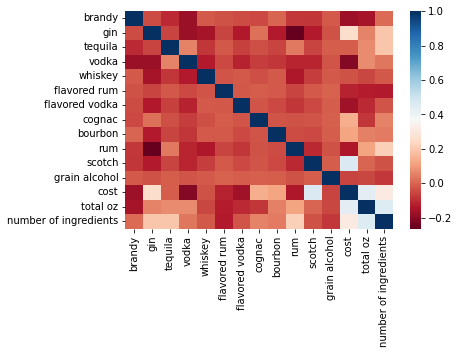

In [128]:
heat_price_corr_heat()

In [132]:
def check_covar_costs():
    df_prices = pd.read_csv(INPUT_PATH, header=None)
    df_prices = df_prices.transpose()
    df_prices.columns = df_prices.loc[0]
    df_prices = df_prices.drop(0)
    df_prices = df_prices[["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]]
    return df_prices

In [133]:
check_covar_costs()

,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,rum,scotch,grain alcohol
1,0.394,0.788,0.659687,0.391845,0.57,0.5,0.39668,2.263396,1.1,0.5,2.3,0.246667


In [130]:
def ols_price_on_liquor():
    """Perform OLS regression of movie Revenue on IMBD Rating and genre dummies, and create png"""

    df = model_data()
    x_cols = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol", "total oz"]
 
    x = df[x_cols]
    y = df["cost"]
    display(df[x_cols])


    model = sm.OLS(y, sm.add_constant(x)).fit()
    model_summary = model.summary()

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.text(
        0.01, 0.05, str(model_summary), {"fontsize": 10}, fontproperties="monospace"
    )
    ax.axis("off")
    plt.tight_layout()



C:\Users\galon\AppData\Local\Temp\ipykernel_11300\2843008722.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  amounts = amounts.sum(axis=1).values.tolist()


,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,rum,scotch,grain alcohol,total oz
strdrink,,,,,,,,,,,,,
1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.50
151 Florida Bushwacker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.50
155 Belmont,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.00
24k nightmare,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.00
3-Mile Long Island Iced Tea,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Winter Rita,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.67
Yellow Bird,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.50
Zipperhead,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00


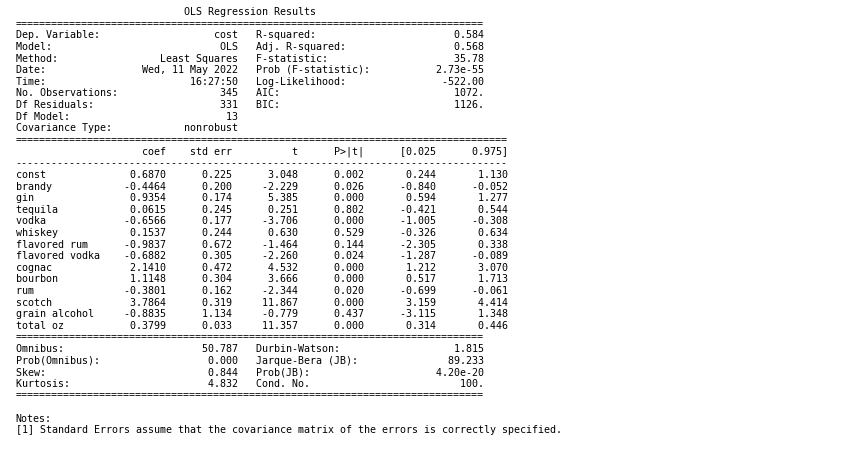

In [135]:
ols_price_on_liquor()

In [133]:
def ols_number_ingreds_on_liquor():
    """Perform OLS regression of movie Revenue on IMBD Rating and genre dummies, and create png"""

    df = model_data()
    x_cols = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol", "total oz"]
 
    x = df[x_cols]
    y = df["number of ingredients"]
    display(df[x_cols])


    model = sm.OLS(y, sm.add_constant(x)).fit()
    model_summary = model.summary()

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.text(
        0.01, 0.05, str(model_summary), {"fontsize": 10}, fontproperties="monospace"
    )
    ax.axis("off")
    plt.tight_layout()

C:\Users\galon\AppData\Local\Temp\ipykernel_11300\2843008722.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  amounts = amounts.sum(axis=1).values.tolist()


,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,rum,scotch,grain alcohol,total oz
strdrink,,,,,,,,,,,,,
1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.50
151 Florida Bushwacker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.50
155 Belmont,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.00
24k nightmare,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.00
3-Mile Long Island Iced Tea,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Winter Rita,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.67
Yellow Bird,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.50
Zipperhead,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00


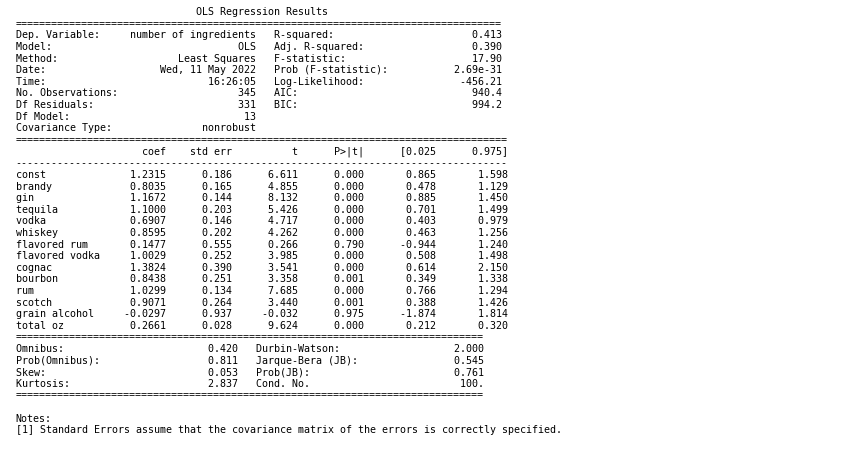

In [134]:
ols_number_ingreds_on_liquor()

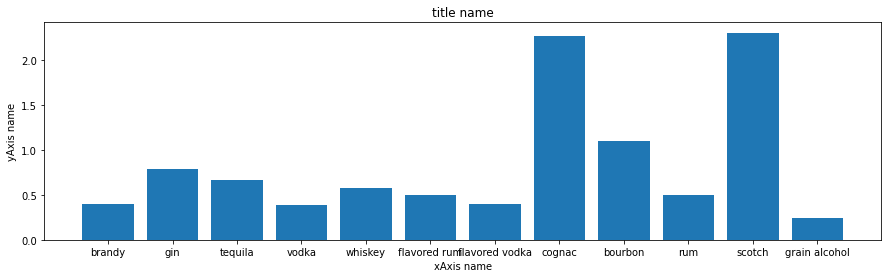

In [74]:
plt.figure(figsize=(15,4))
plt.bar(alc,cost)
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

In [ ]:
covar_costs = check_covar_costs()
alc = covar_costs.columns.values.tolist()
cost = covar_costs.loc[1].values.tolist()